In [35]:
import sys
sys.path.append('/home/xinyiz/pamrats')

import time
import os

import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim

# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import average_precision_score

import gae.gae.optimizer as optimizer
import gae.gae.model
import gae.gae.preprocessing as preprocessing

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [3]:
plottype='pca'
npc=40
pca=PCA()
plot_samples={'disease13':'AD_mouse9494','control13':'AD_mouse9498','disease8':'AD_mouse9723','control8':'AD_mouse9735'}
plot_sample_X=['corrected','scaled']
plotsavepath='/mnt/xinyi/pamrats/plots/data/pca/'
seed=3

In [4]:
# Set cuda and seed
np.random.seed(seed)


In [68]:
#Load data
scaleddata=scanpy.read_h5ad('/mnt/xinyi/2021-01-13-mAD-test-dataset/2020-12-27-starmap-mAD-scaled.h5ad')

featureslist={}
featureslist['disease13X_corrected']=scaleddata.layers['corrected'][scaleddata.obs['sample']=='AD_mouse9494']
featureslist['control13X_corrected']=scaleddata.layers['corrected'][scaleddata.obs['sample']=='AD_mouse9498']
featureslist['disease8X_corrected']=scaleddata.layers['corrected'][scaleddata.obs['sample']=='AD_mouse9723']
featureslist['control8X_corrected']=scaleddata.layers['corrected'][scaleddata.obs['sample']=='AD_mouse9735']
featureslist['disease13X_scaled']=scaleddata.layers['scaled'][scaleddata.obs['sample']=='AD_mouse9494']
featureslist['control13X_scaled']=scaleddata.layers['scaled'][scaleddata.obs['sample']=='AD_mouse9498']
featureslist['disease8X_scaled']=scaleddata.layers['scaled'][scaleddata.obs['sample']=='AD_mouse9723']
featureslist['control8X_scaled']=scaleddata.layers['scaled'][scaleddata.obs['sample']=='AD_mouse9735']

In [5]:
def plotembeddingbyCT(ctlist,savename,excludelist,embedding,savepath,plotname,plotdimx=0,plotdimy=1):
    celltypes=np.unique(ctlist)
    celltypes_dict={}
    idx=0
    for ct in celltypes:
        celltypes_dict[ct]=idx
        idx+=1
        
    colortest=sns.color_palette("husl", celltypes.size)
    np.random.shuffle(colortest)
    fig, ax = plt.subplots(dpi=400)
    for ct in celltypes:
        if ct in excludelist:
            continue
        idx=(ctlist==ct)
        ax.scatter(
            embedding[idx, plotdimx],
            embedding[idx, plotdimy],
            color=colortest[celltypes_dict[ct]],label=ct,s=3,alpha=0.5
            )

    plt.gca().set_aspect('equal', 'datalim')
    fig.set_figheight(10)
    fig.set_figwidth(10)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])
    # Put a legend below current axis
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=5)
#     ax.legend(ncol=3)
    plt.title(plotname, fontsize=24)
    plt.savefig(os.path.join(savepath,savename+'.jpg'))
    plt.show()

def plotembeddingbyCT_contrast(ctlist,savename,excludelist,embedding,savepath,plotname,plotdimx=0,plotdimy=1): 
    celltypes=np.unique(ctlist)
    celltypes_dict={}
    idx=0
    for ct in celltypes:
        celltypes_dict[ct]=idx
        idx+=1

    colortest=sns.color_palette("tab10")
    if not os.path.exists(os.path.join(savepath)):
        os.makedirs(savepath)

    for ct in celltypes:
        fig, ax = plt.subplots()
        if ct == 'Unassigned':
            continue

        idx=(ctlist!=ct)
        ax.scatter(
            embedding[idx, plotdimx],
            embedding[idx, plotdimy],
            color=colortest[1],label='others',s=1,alpha=0.5
            )

        idx=(ctlist==ct)
        ax.scatter(
            embedding[idx, plotdimx],
            embedding[idx, plotdimy],
            color=colortest[0],label=ct,s=3,alpha=0.5
            )

        plt.gca().set_aspect('equal', 'datalim')
        fig.set_figheight(10)
        fig.set_figwidth(10)
        ax.legend()
        plt.title(plotname, fontsize=24)
        plt.gcf().savefig(os.path.join(savepath,savename+'_'+ct+'.jpg'))
        plt.show()
    #     plt.close()

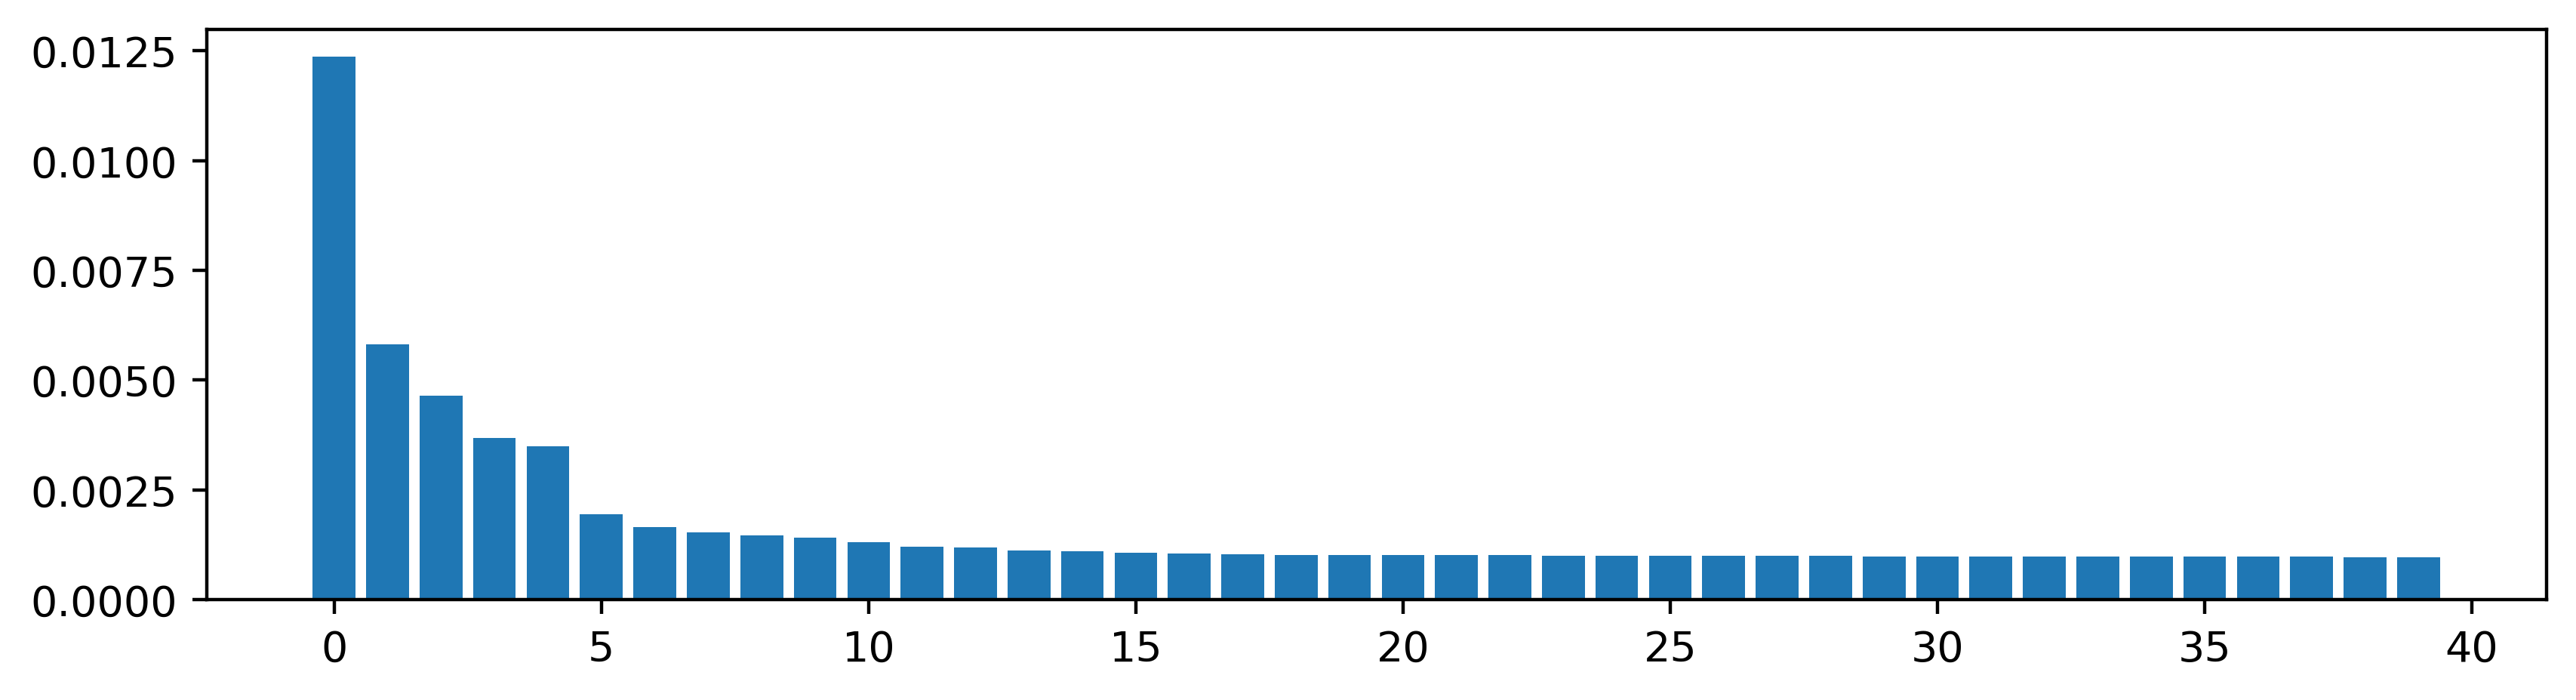

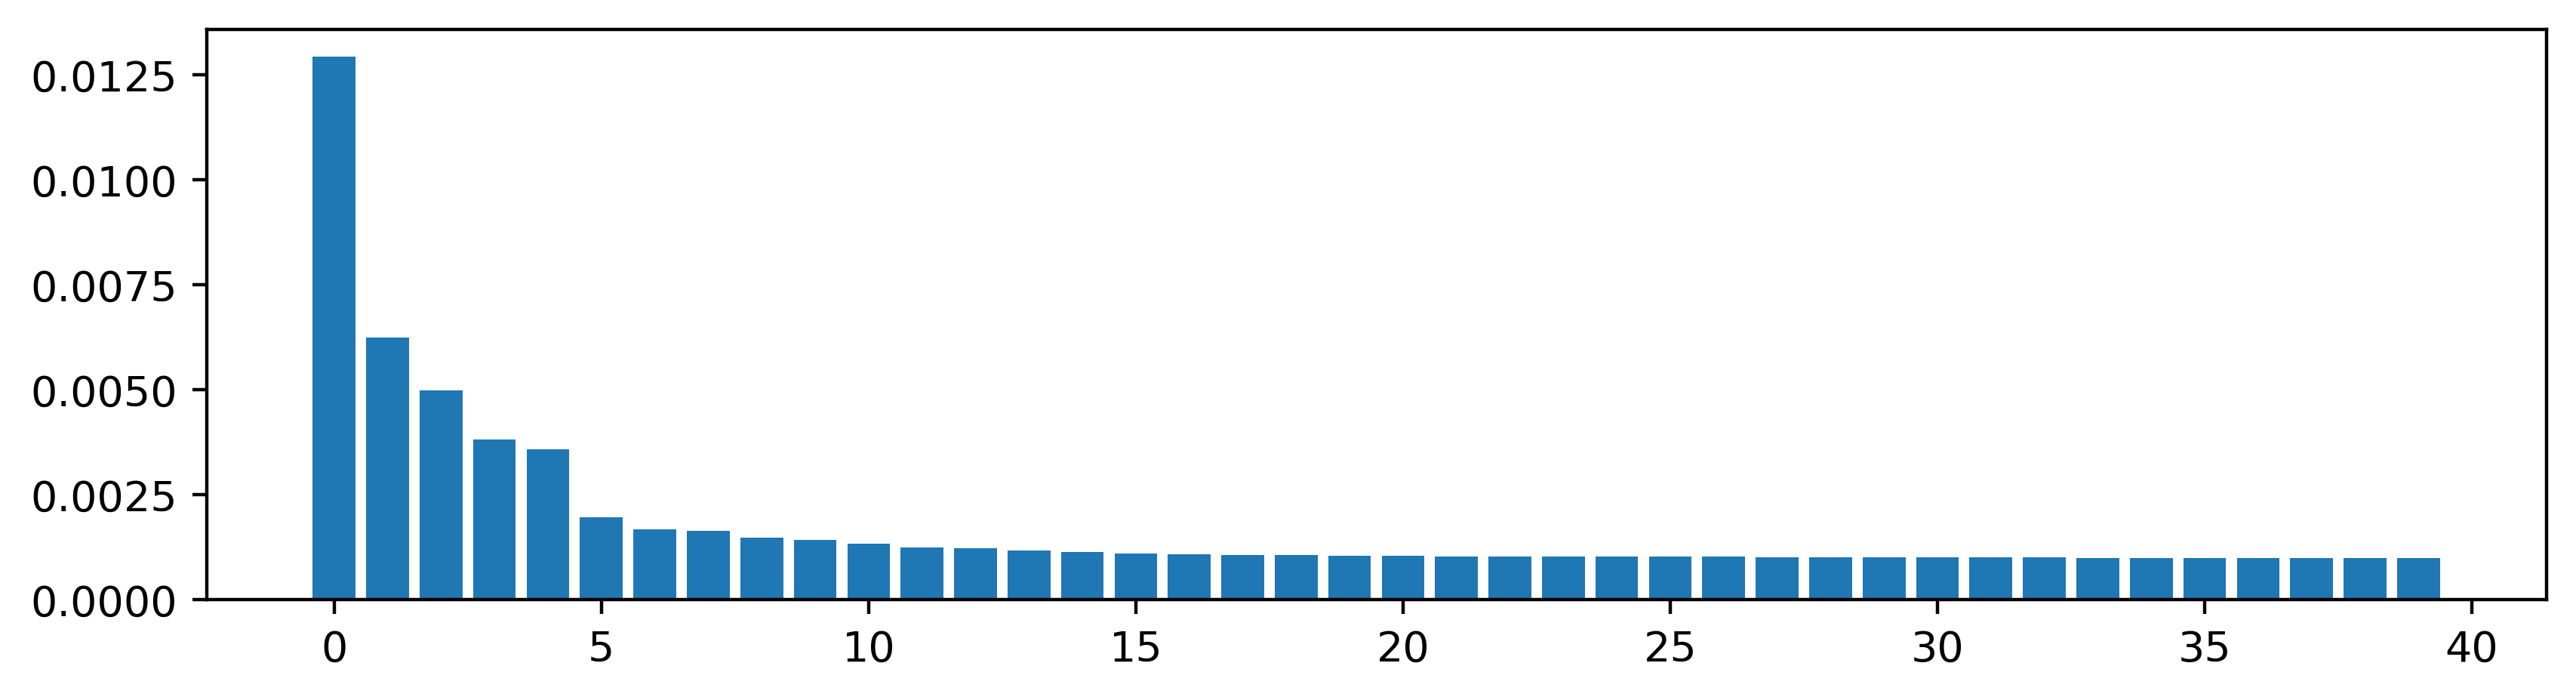

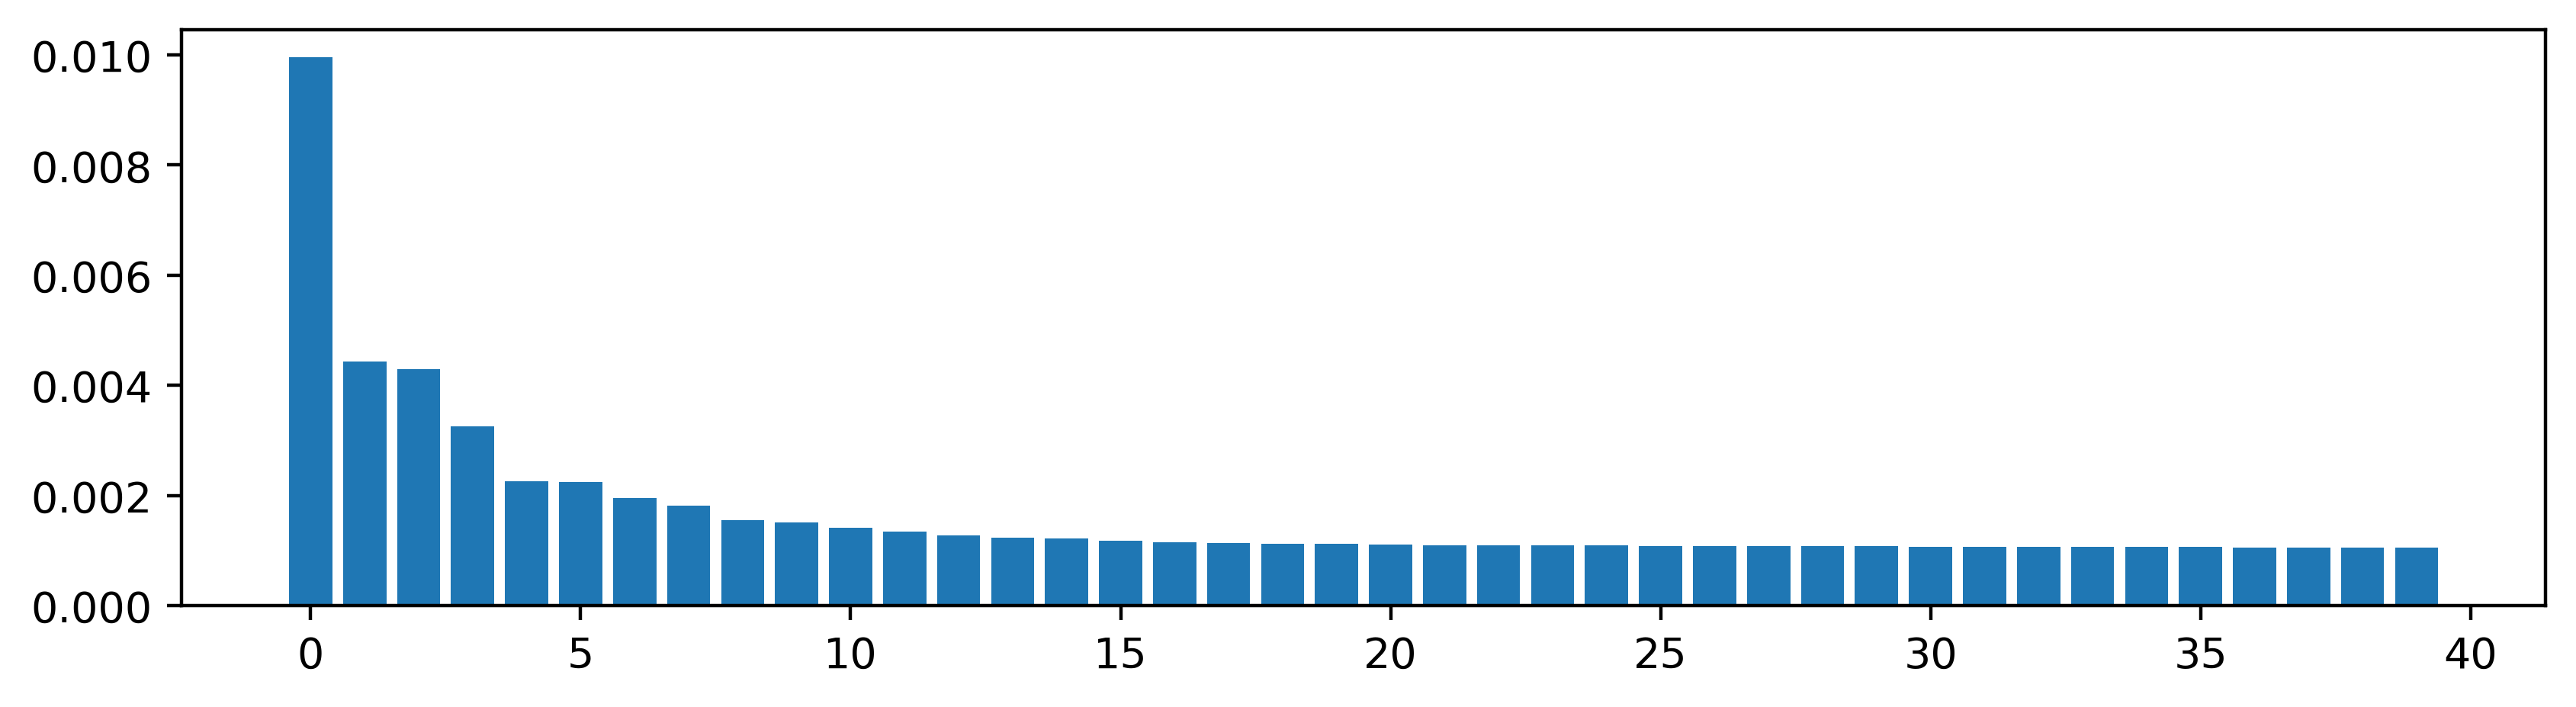

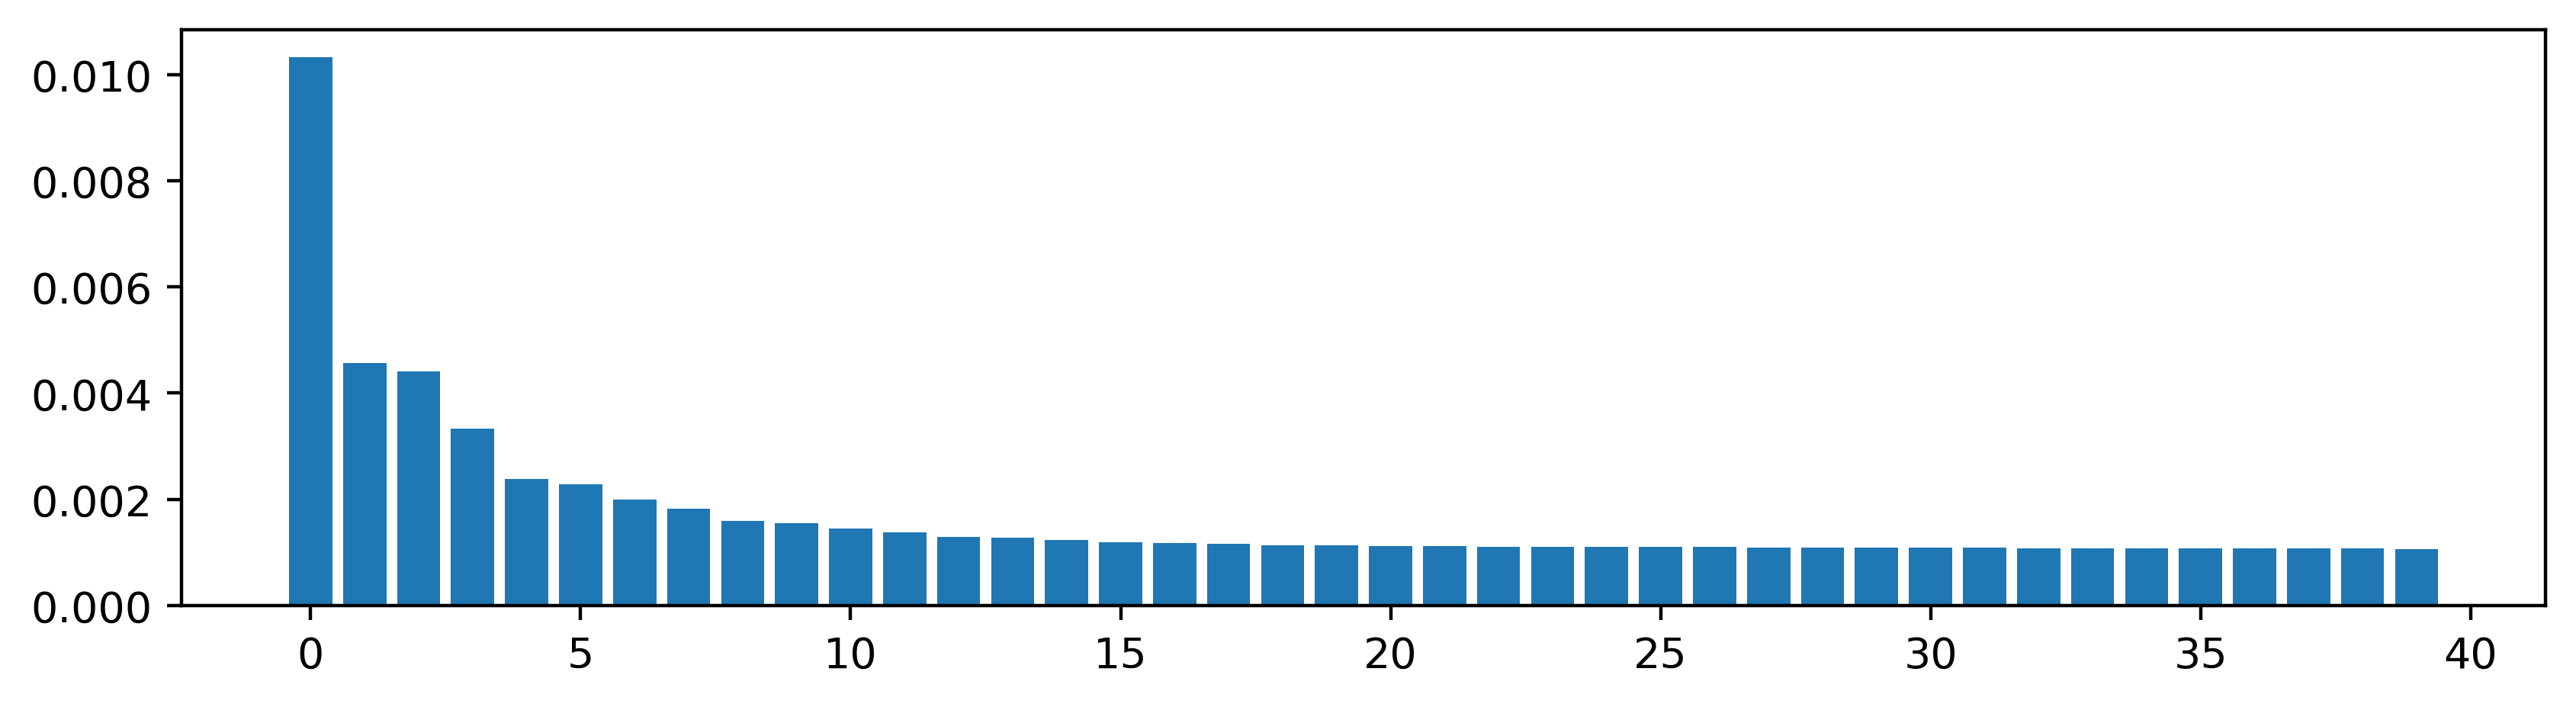

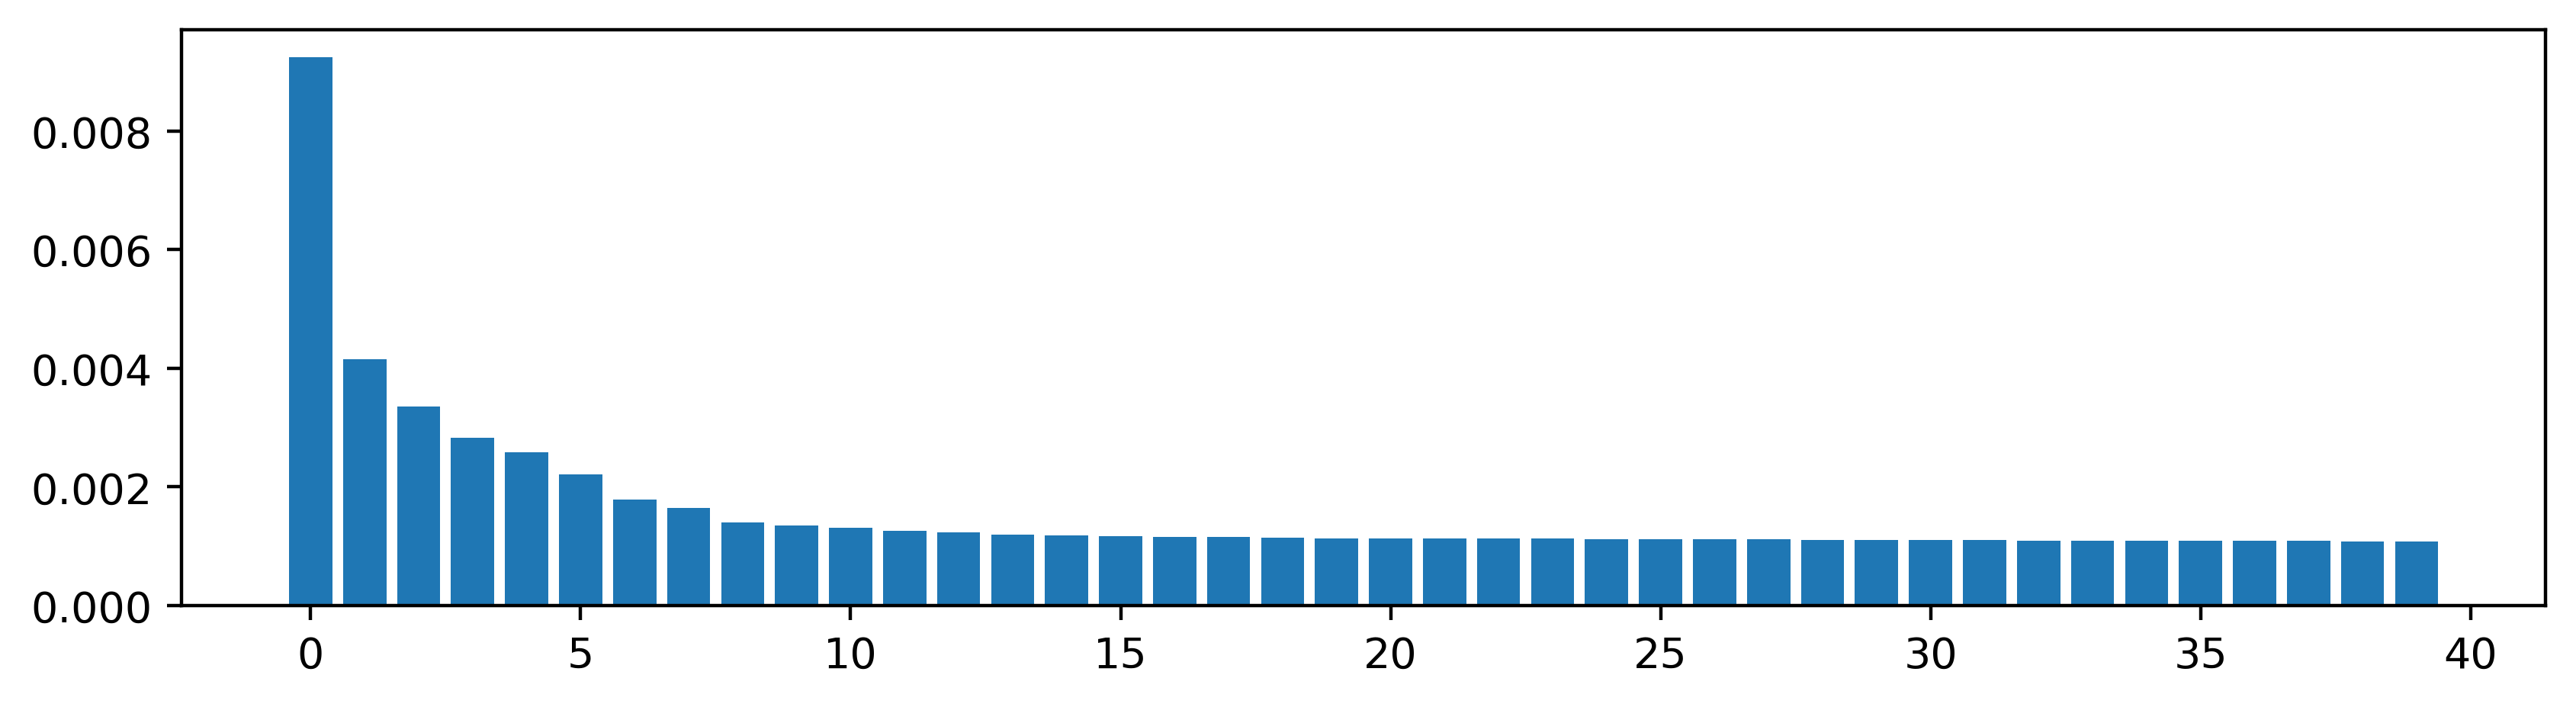

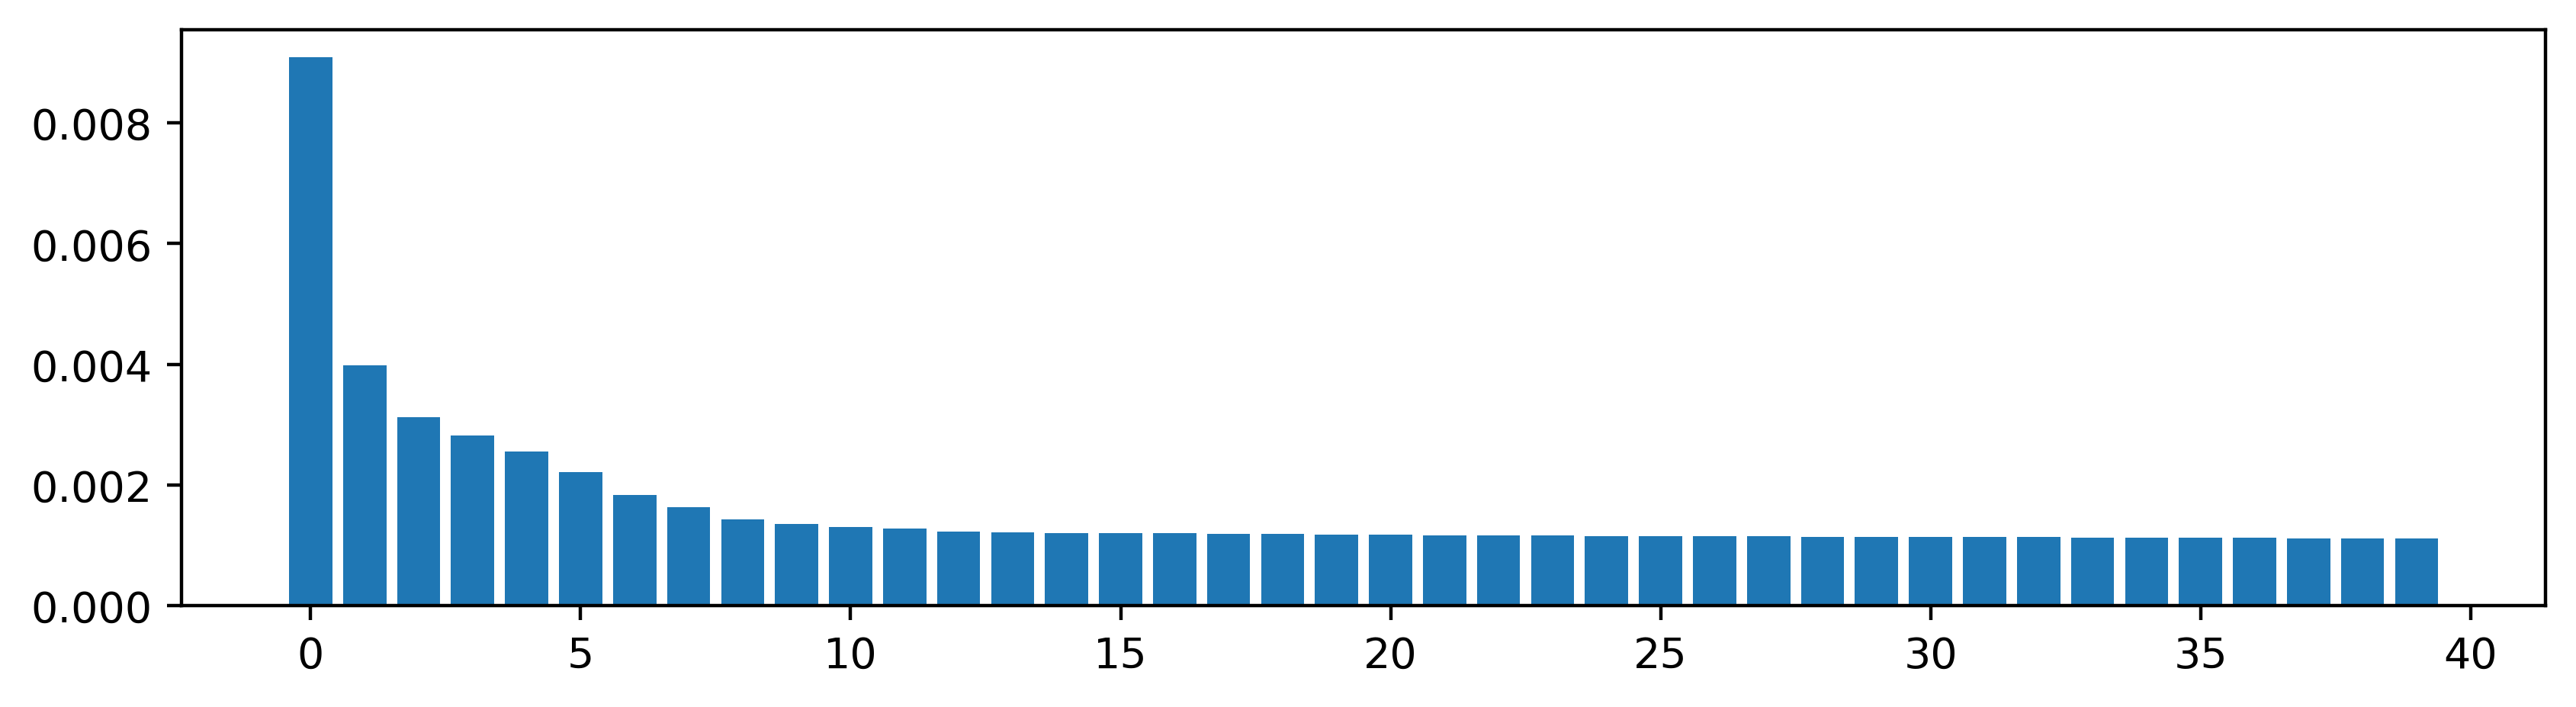

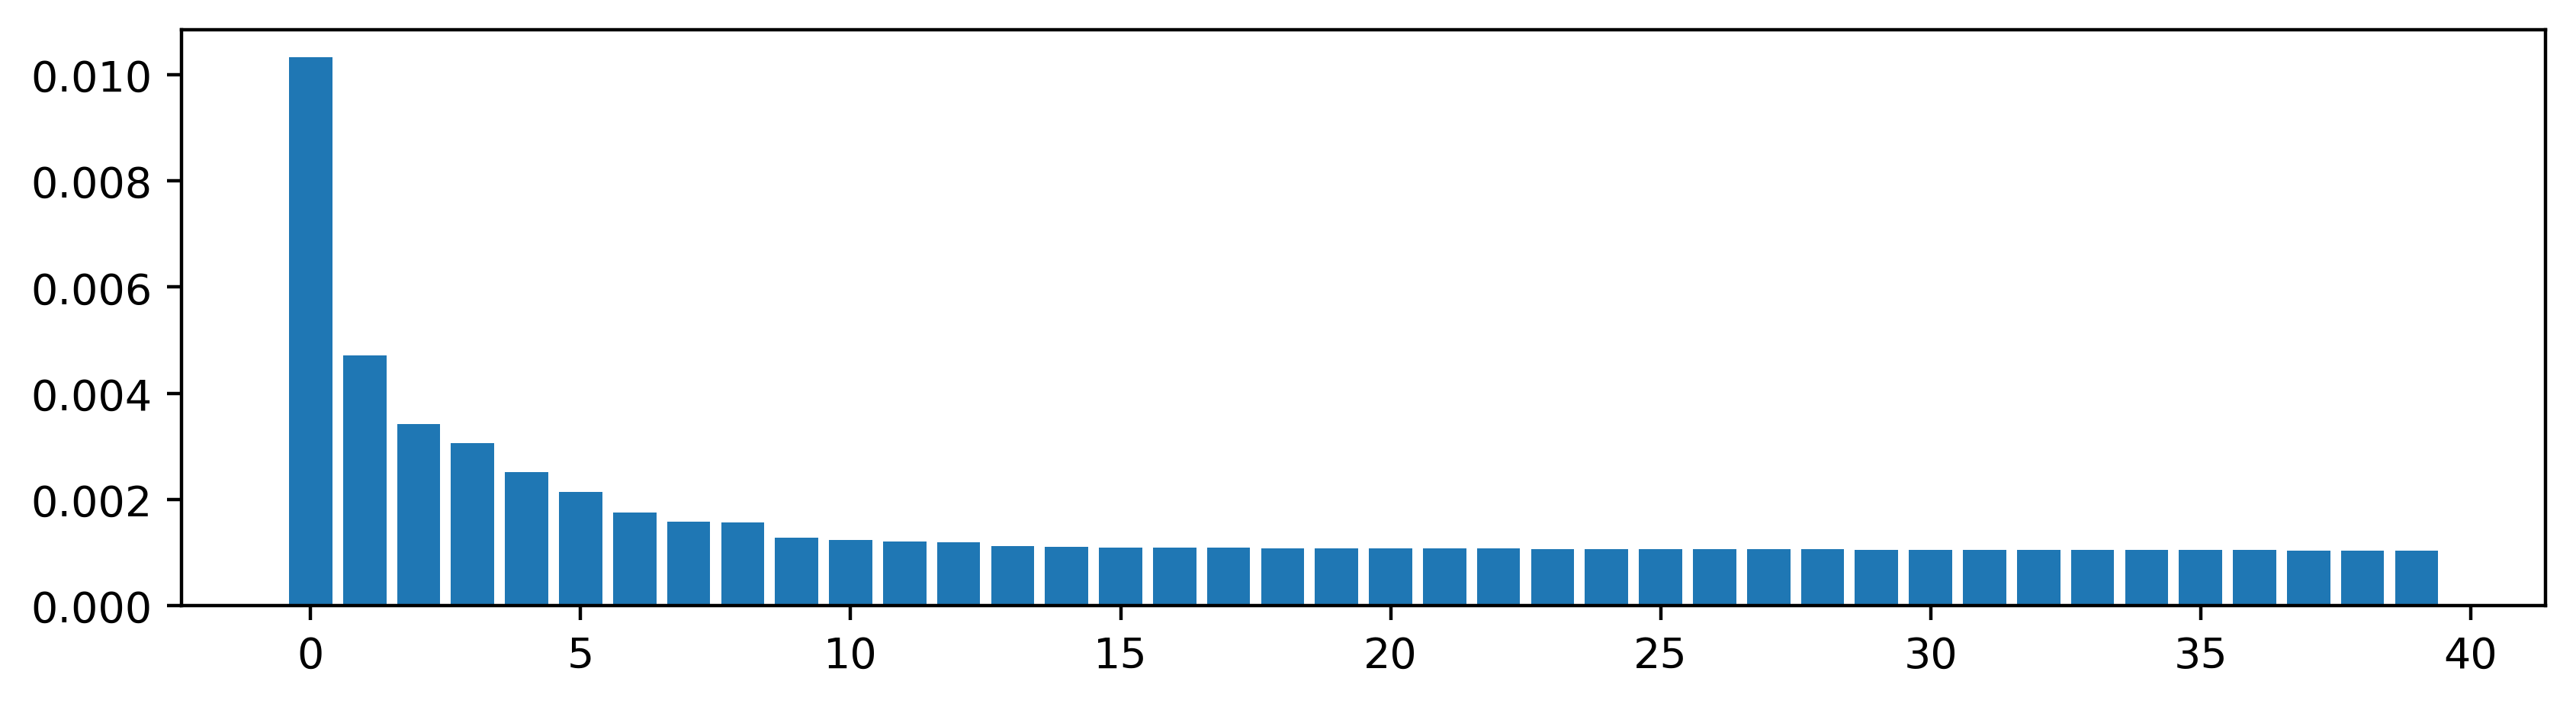

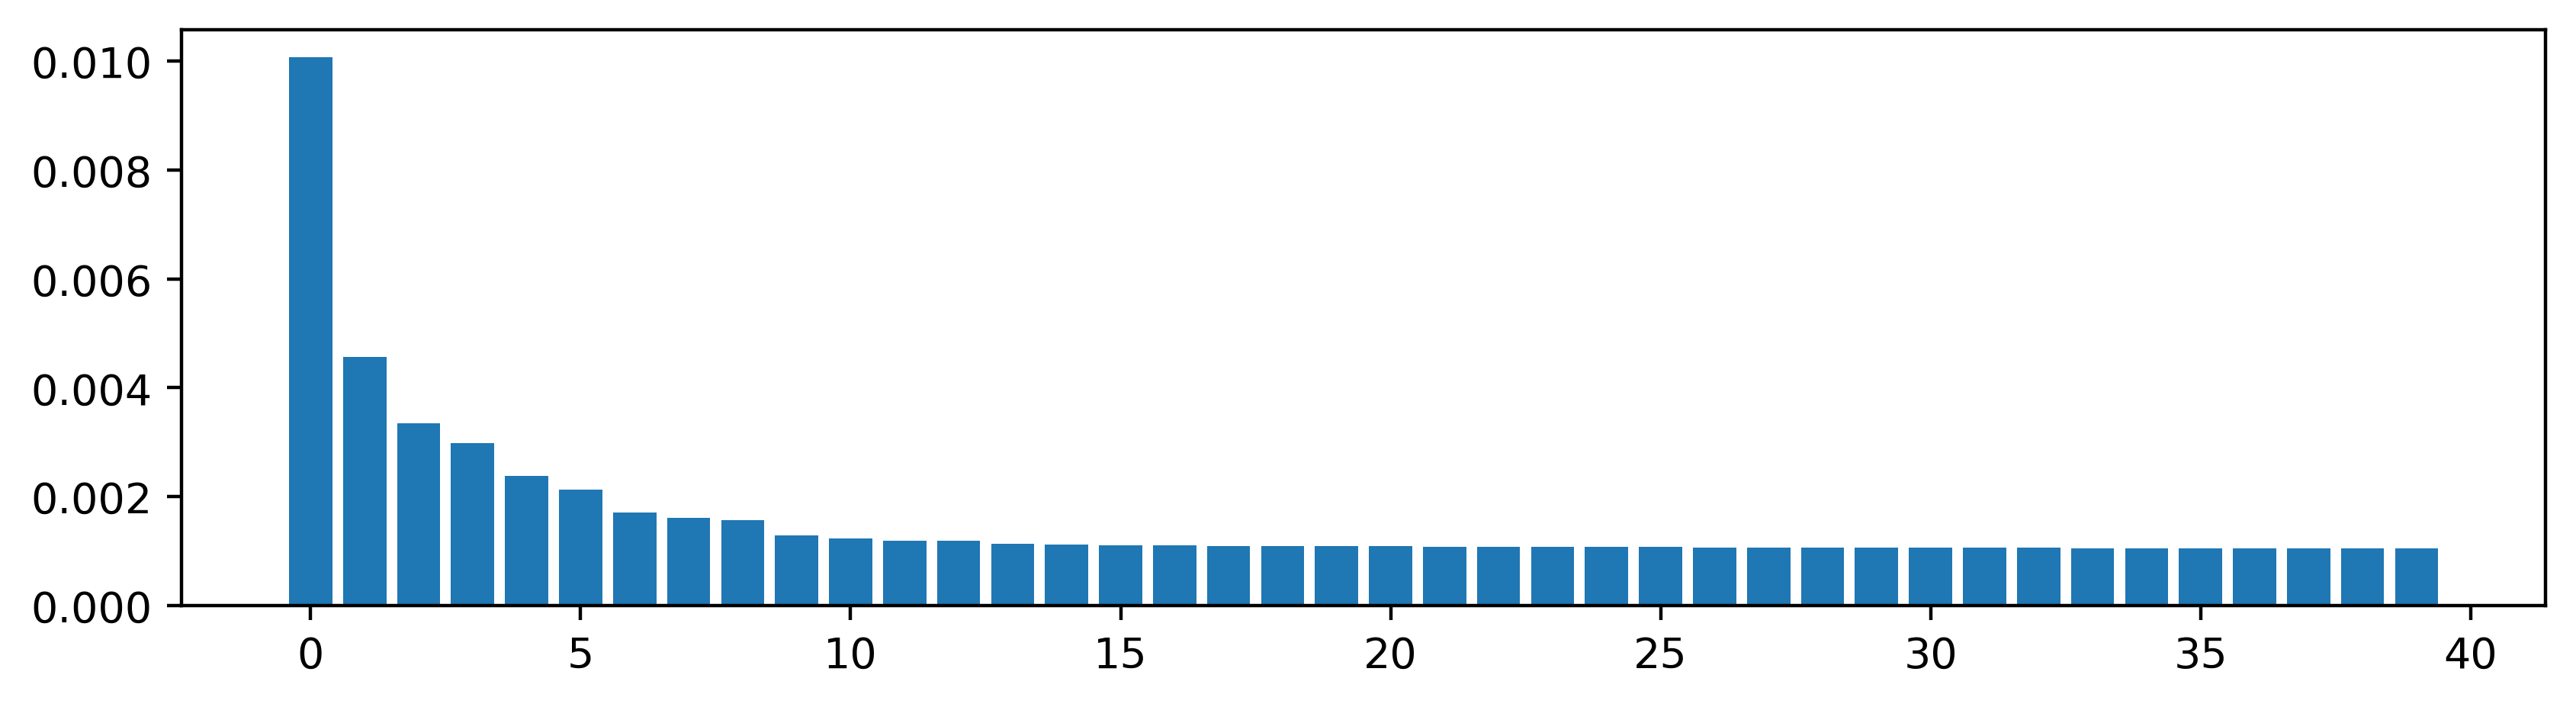

In [11]:
for s in plot_samples.keys():
    sampleidx=plot_samples[s]
    celltype_broad=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'top_level']
    celltype_sub=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'cell_type_label']
    region=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'region']
    for xcorr in plot_sample_X:
        samplename=s+'X_'+xcorr
        features=featureslist[samplename]
        savedir=os.path.join(plotsavepath,samplename)
        if not os.path.exists(savedir):
            os.mkdir(savedir)
        
        if plottype=='umap':
            reducer = umap.UMAP()
            embedding = reducer.fit_transform(mu.cpu().detach().numpy())
        elif plottype=='pca':
            pca.fit(features)
            fig, ax = plt.subplots(dpi=400)
            fig.set_figheight(2.5)
            fig.set_figwidth(10)
            plt.bar(np.arange(npc),pca.explained_variance_ratio_[:npc])
            plt.savefig(os.path.join(savedir,'varRatio_'+str(npc)+'.jpg'))
            embedding=pca.transform(features)
        
#         plotembeddingbyCT(celltype_broad,'celltype_broad',[],embedding,savedir,plottype+' of '+s)
#         plotembeddingbyCT(celltype_sub,'celltype_sub',[],embedding,savedir,plottype+' of '+s)
#         plotembeddingbyCT(region,'region',[],embedding,savedir,plottype+' of '+s)
        
#         plotembeddingbyCT_contrast(celltype_sub,'celltype_sub',[],embedding,os.path.join(savedir,'contrast'),plottype+' of '+s)

In [69]:
pca.fit(featureslist['control13X_scaled'])


PCA()

In [77]:
np.sum(pca.explained_variance_ratio_>=(pca.explained_variance_ratio_[0]*0.1))

58

In [5]:
featureraw=scanpy.read_h5ad('/mnt/xinyi/2021-01-13-mAD-test-dataset/2020-12-27-starmap-mAD-raw.h5ad')

In [9]:
featureraw_control13=featureraw.X[featureraw.obs['sample']=='AD_mouse9498']

In [10]:
pca.fit(featureraw_control13)

PCA()

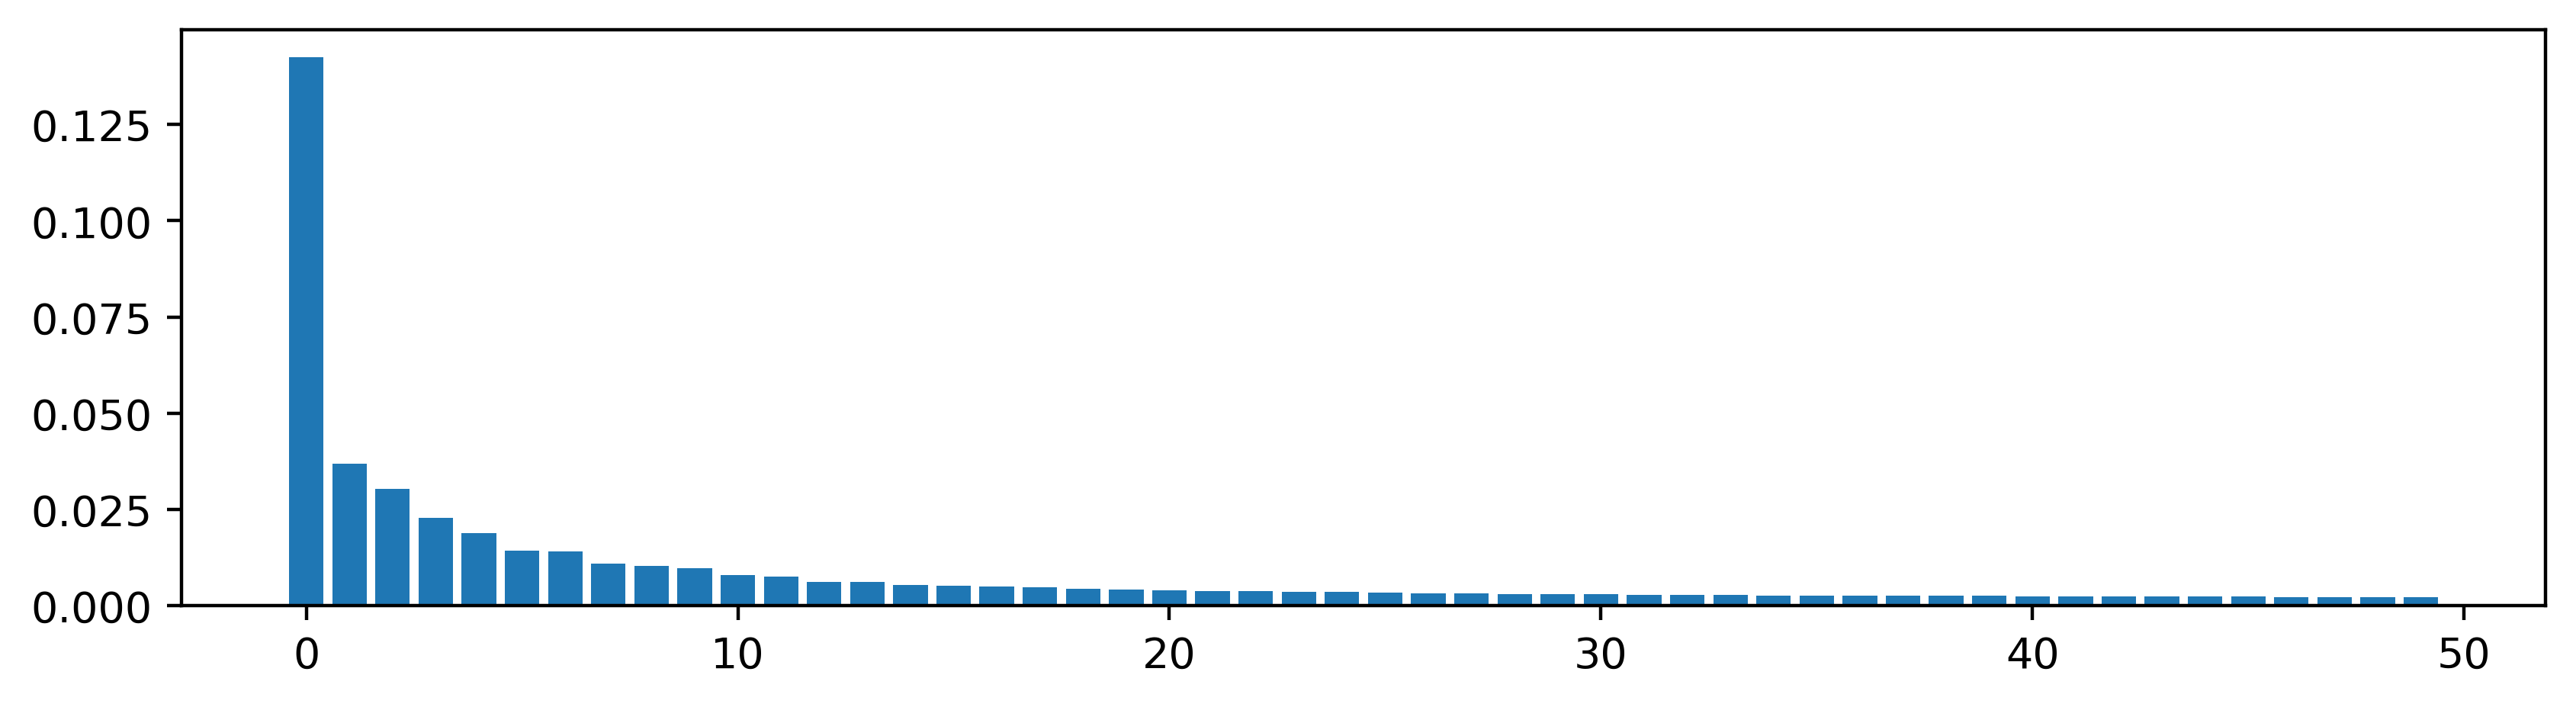

In [15]:
npc=50
savedir=os.path.join(plotsavepath,'control13X_raw')
fig, ax = plt.subplots(dpi=400)
fig.set_figheight(2.5)
fig.set_figwidth(10)
plt.bar(np.arange(npc),pca.explained_variance_ratio_[:npc])
plt.savefig(os.path.join(savedir,'varRatio_'+str(npc)+'.jpg'))

In [70]:
pca.explained_variance_ratio_[0]

0.010322658

In [22]:
np.sum(pca.explained_variance_ratio_>=(pca.explained_variance_ratio_[0]*0.75))

1

log2(x+1/2)

In [23]:
featurelog_control13=np.log2(featureraw_control13+1/2)

In [55]:
pca.fit(featurelog_control13)

PCA()

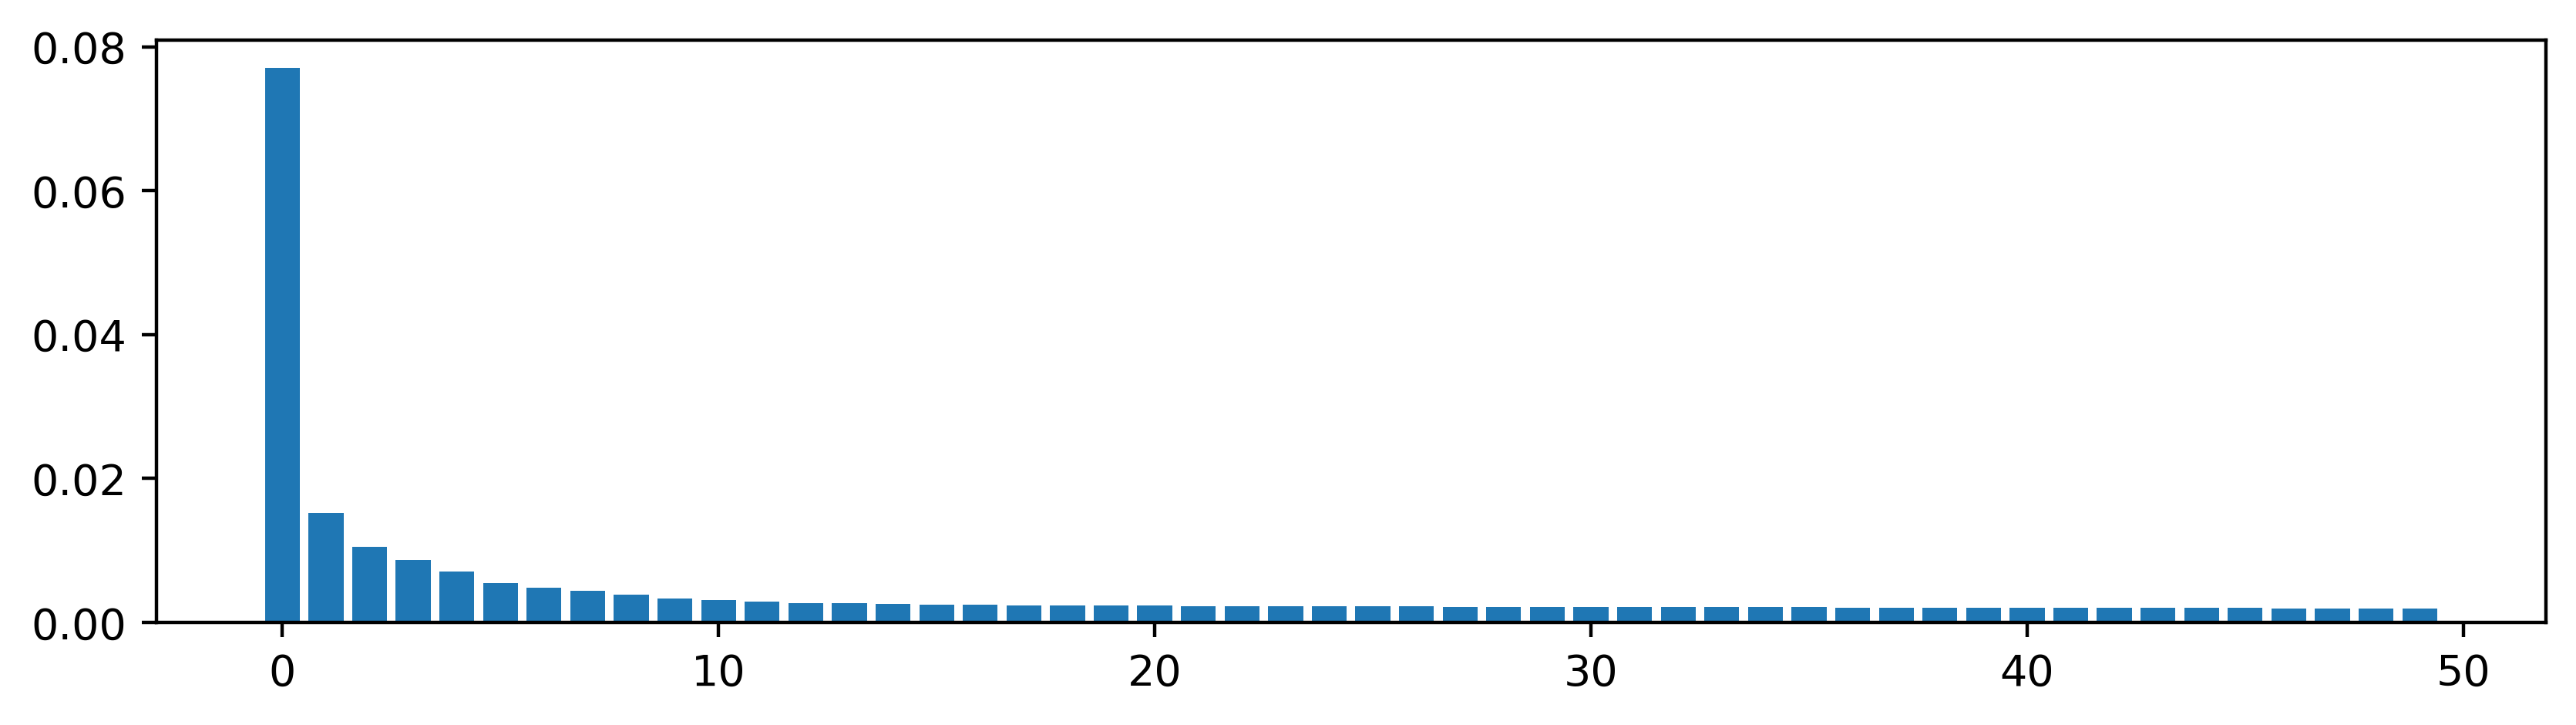

In [41]:
npc=50
savedir=os.path.join(plotsavepath,'control13X_log')
fig, ax = plt.subplots(dpi=400)
fig.set_figheight(2.5)
fig.set_figwidth(10)
plt.bar(np.arange(npc),pca.explained_variance_ratio_[:npc])
plt.savefig(os.path.join(savedir,'varRatio_'+str(npc)+'.jpg'))

In [28]:
pca.explained_variance_ratio_[0]

0.07705192

In [56]:
np.sum(pca.explained_variance_ratio_>=(pca.explained_variance_ratio_[0]*0.005))

709

+ min max

In [36]:
scaler = MinMaxScaler()
featurelog_control13_minmax=np.transpose(scaler.fit_transform(np.transpose(featurelog_control13)))

In [44]:
pca.fit(featurelog_control13_minmax)

PCA()

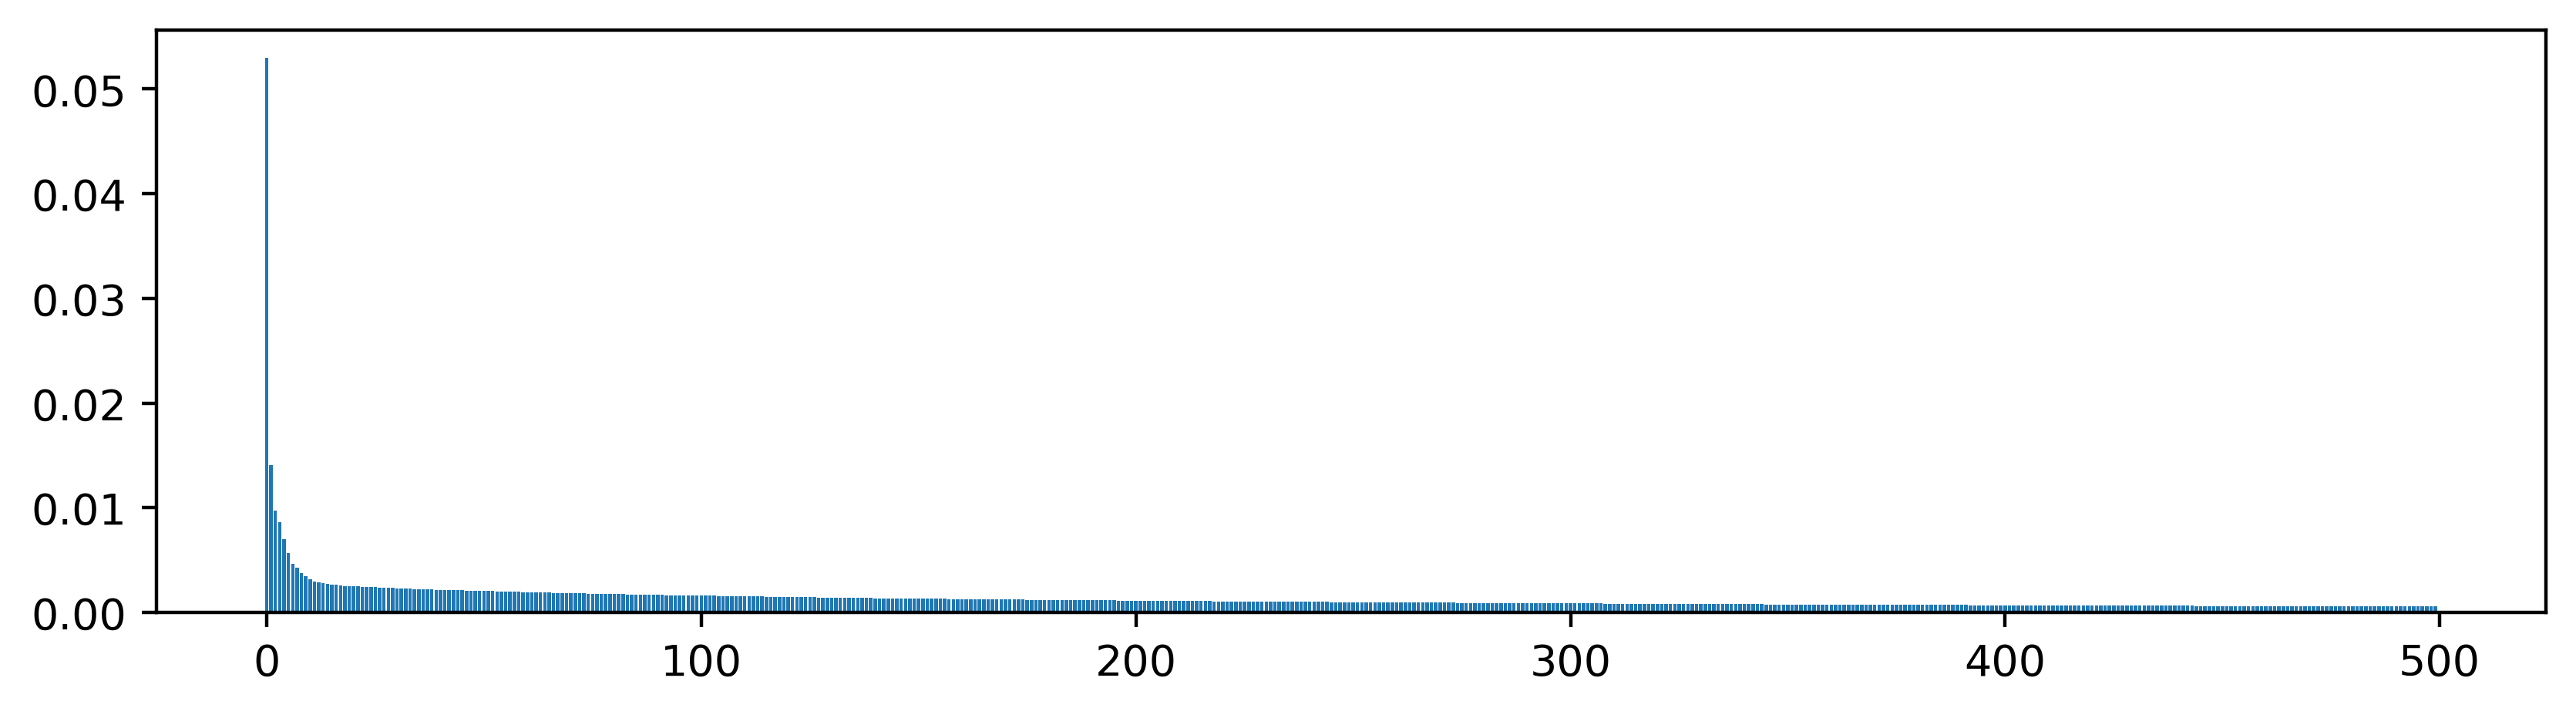

In [46]:
npc=500
savedir=os.path.join(plotsavepath,'control13X_logminmax')
fig, ax = plt.subplots(dpi=400)
fig.set_figheight(2.5)
fig.set_figwidth(10)
plt.bar(np.arange(npc),pca.explained_variance_ratio_[:npc])
plt.savefig(os.path.join(savedir,'varRatio_'+str(npc)+'.jpg'))

In [47]:
pca.explained_variance_ratio_[0]

0.052971847

In [54]:
np.sum(pca.explained_variance_ratio_>=(pca.explained_variance_ratio_[0]*0.05))

16

log2(10^4*x/libsize+1/2)

In [57]:
sum_of_rows = featureraw_control13.sum(axis=1)
featureloglibnorm_control13=np.log2(featureraw_control13/ sum_of_rows[:, np.newaxis]*10000+1/2)

In [58]:
pca.fit(featureloglibnorm_control13)

PCA()

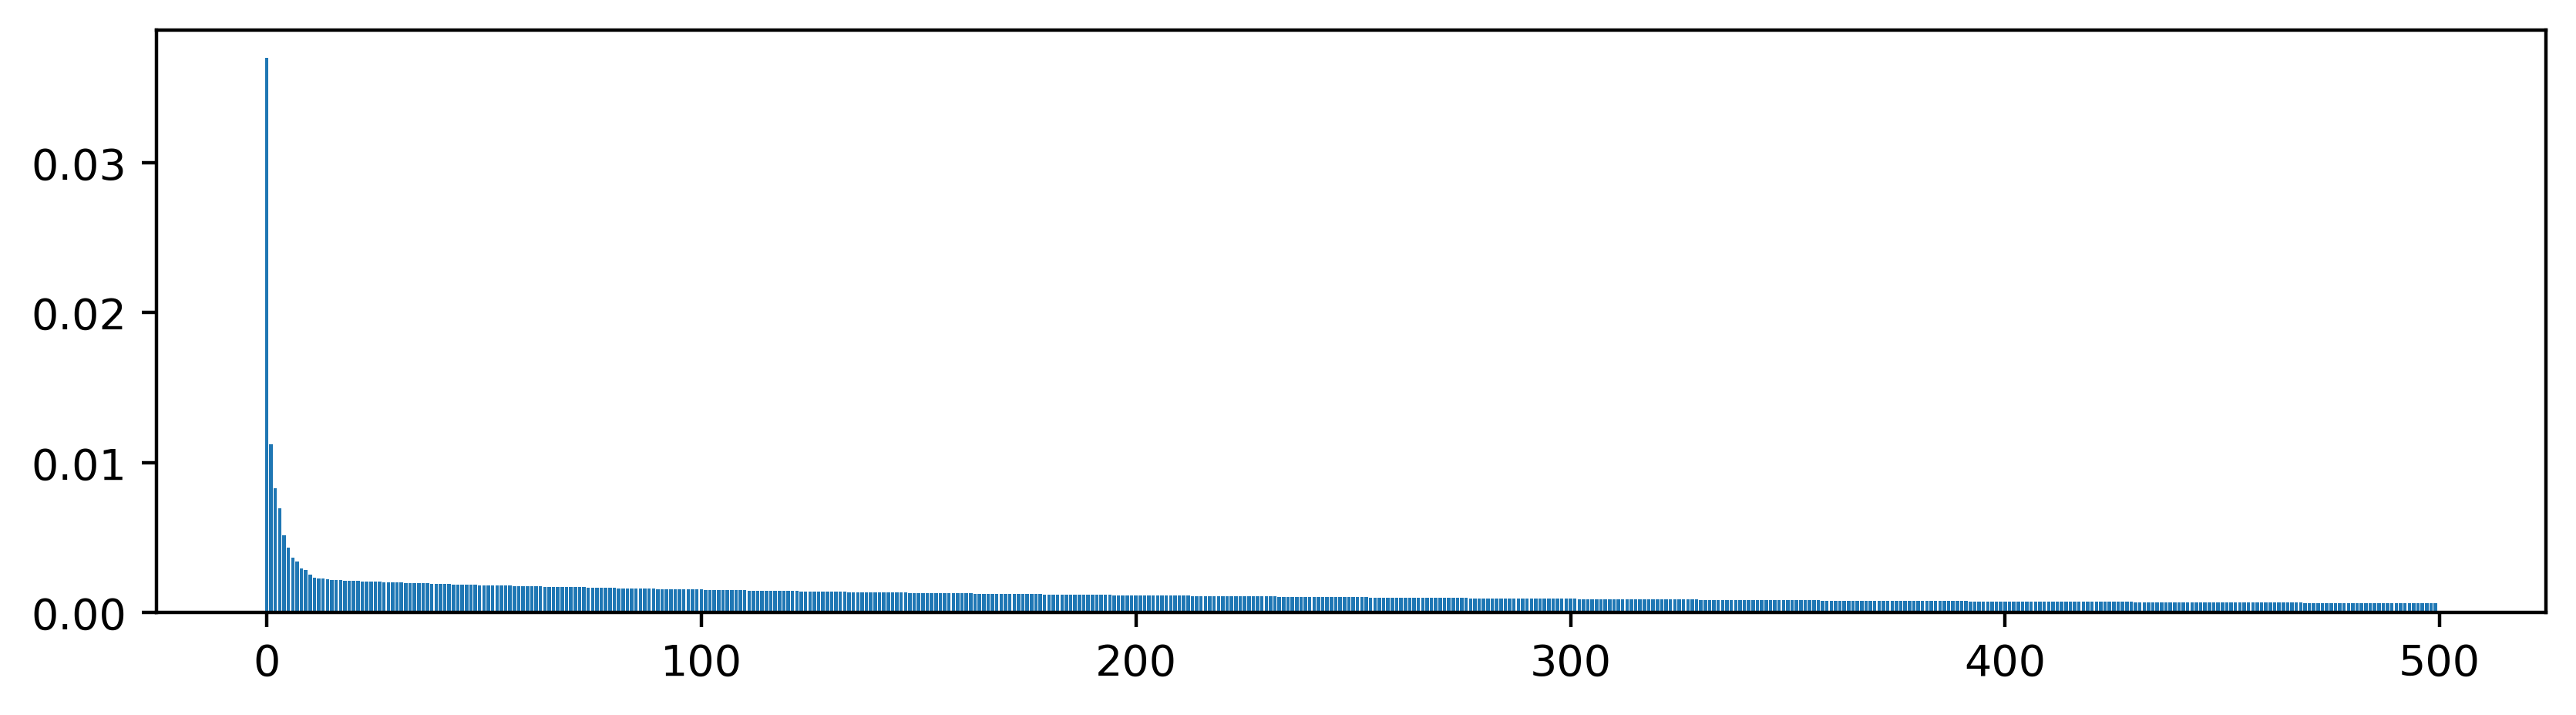

In [60]:
npc=500
savedir=os.path.join(plotsavepath,'control13X_loglibnorm')
fig, ax = plt.subplots(dpi=400)
fig.set_figheight(2.5)
fig.set_figwidth(10)
plt.bar(np.arange(npc),pca.explained_variance_ratio_[:npc])
plt.savefig(os.path.join(savedir,'varRatio_'+str(npc)+'.jpg'))

In [61]:
pca.explained_variance_ratio_[0]

0.03699166

In [66]:
np.sum(pca.explained_variance_ratio_>=(pca.explained_variance_ratio_[0]*0.05))

47

+ min max by cell

In [78]:
scaler = MinMaxScaler()
featureloglibnorm_control13_minmax=np.transpose(scaler.fit_transform(np.transpose(featureloglibnorm_control13)))

In [79]:
pca.fit(featureloglibnorm_control13_minmax)

PCA()

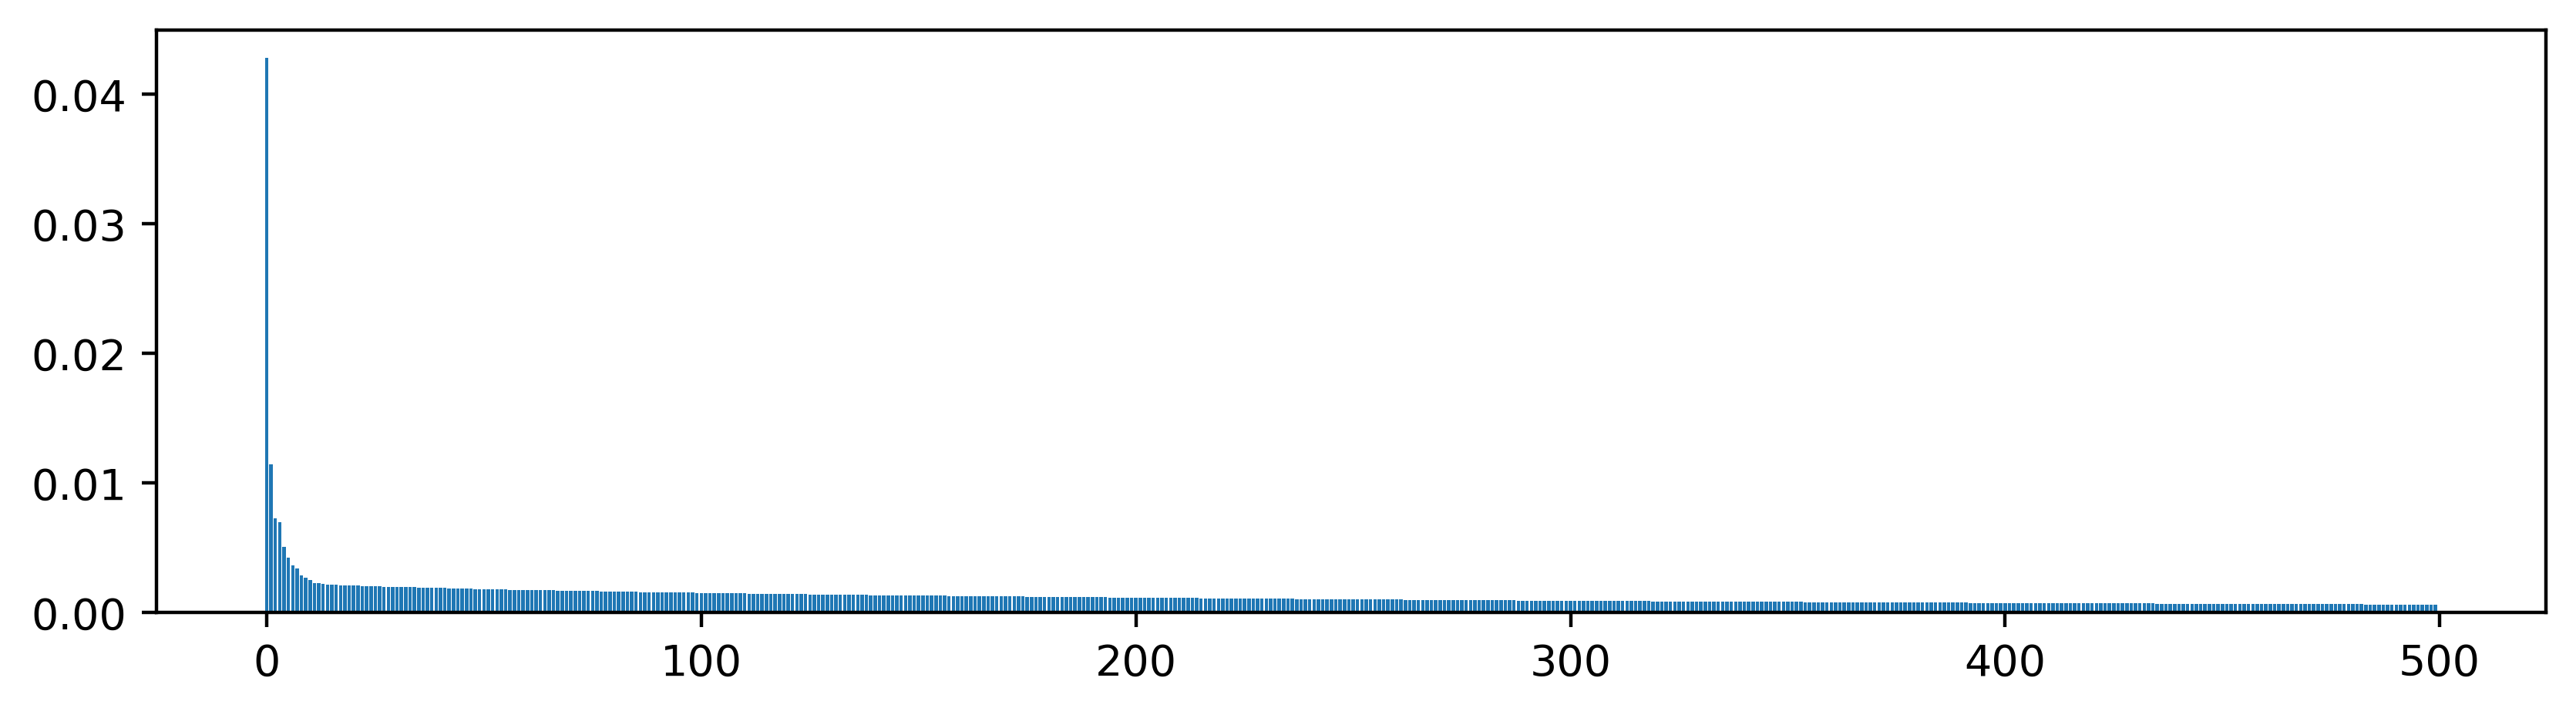

In [81]:
npc=500
savedir=os.path.join(plotsavepath,'control13X_loglibnorm_minmax')
fig, ax = plt.subplots(dpi=400)
fig.set_figheight(2.5)
fig.set_figwidth(10)
plt.bar(np.arange(npc),pca.explained_variance_ratio_[:npc])
plt.savefig(os.path.join(savedir,'varRatio_'+str(npc)+'.jpg'))

In [82]:
pca.explained_variance_ratio_[0]

0.042815086

In [87]:
np.sum(pca.explained_variance_ratio_>=(pca.explained_variance_ratio_[0]*0.05))

17